06/20/2023 02:29:01PM - __main__DEBUG: python: 3.8.10
06/20/2023 02:29:01PM - __main__DEBUG: opencv: 4.7.0
06/20/2023 02:29:01PM - __main__DEBUG: desired kp: 642
06/20/2023 02:29:01PM - __main__DEBUG: kp: 5773, threshold: 0.05
06/20/2023 02:29:01PM - __main__DEBUG: kp: 5176, threshold: 0.060000000000000005
06/20/2023 02:29:01PM - __main__DEBUG: kp: 4661, threshold: 0.07
06/20/2023 02:29:02PM - __main__DEBUG: kp: 4076, threshold: 0.08
06/20/2023 02:29:02PM - __main__DEBUG: kp: 3626, threshold: 0.09
06/20/2023 02:29:02PM - __main__DEBUG: kp: 3156, threshold: 0.09999999999999999
06/20/2023 02:29:02PM - __main__DEBUG: kp: 2694, threshold: 0.10999999999999999
06/20/2023 02:29:02PM - __main__DEBUG: kp: 2232, threshold: 0.11999999999999998
06/20/2023 02:29:02PM - __main__DEBUG: kp: 1792, threshold: 0.12999999999999998
06/20/2023 02:29:02PM - __main__DEBUG: kp: 1396, threshold: 0.13999999999999999
06/20/2023 02:29:02PM - __main__DEBUG: kp: 1092, threshold: 0.15
06/20/2023 02:29:03PM - __main__

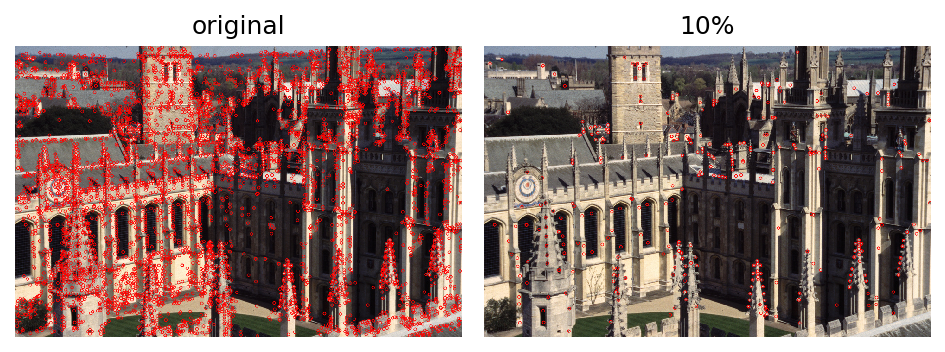

06/20/2023 02:29:03PM - __main__DEBUG: The keypoints of the noisy image are roughly the same as those of the original image.          This means SIFT is not affected by noise.          This is because SIFT finds local keypoints.


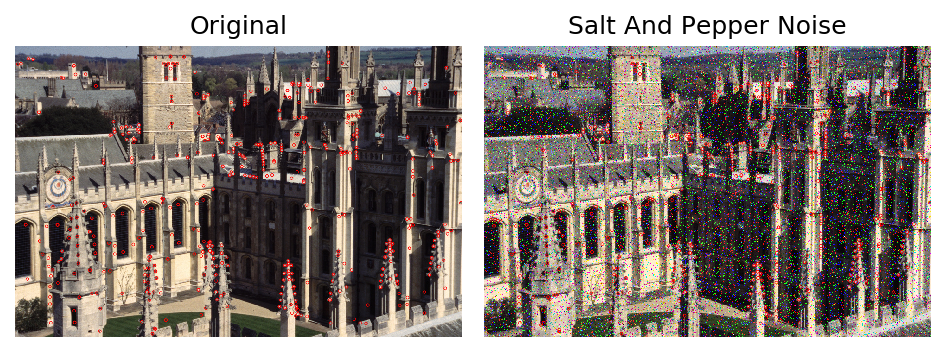

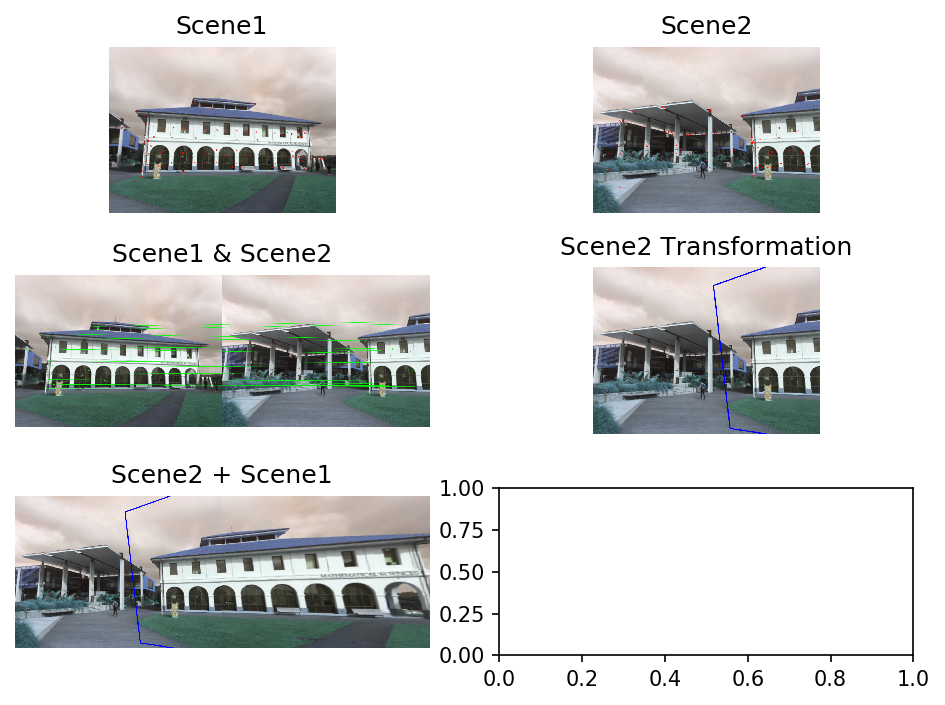

In [1]:
import pathlib
import os
import sys
import subprocess
import logging
import platform
import math

from dataclasses import dataclass

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from skimage.util import random_noise 

global global_logger

def fatal_error(msg):
  global_logger.critical(msg)
  breakpoint()
  sys.exit()

def warn(msg):
  global_logger.warning(msg)
  # NOTE(Ryan): Disable by passing -O to interpreter
  if __debug__:
    breakpoint()
    sys.exit()

def trace(msg):
  if __debug__:
    global_logger.debug(msg)

def make_empty_matrix(n):
  return [[0] * n for i in range(n)]


def clamp(val, limit):
  clamped_val = val

  if val < 0:
    clamped_val = 0
  elif val >= limit:
    clamped_val = limit - 1
  
  return clamped_val

def translate(x0, x1, val, x2, x3):
  val_fraction = ((val - x0) / (x1 - x0))
  
  return x2 + (val_fraction * (x3 - x2))

def make_k3x3_laplace():
  k3x3 = make_empty_matrix(3)

  k3x3[0][0] = 0 
  k3x3[1][0] = 1 
  k3x3[2][0] = 0 

  k3x3[0][1] = 1 
  k3x3[1][1] = -4 
  k3x3[2][1] = 1 

  k3x3[0][2] = 0 
  k3x3[1][2] = 1 
  k3x3[2][2] = 0 

  return k3x3

def convolve_k3x3_laplace(k3x3, m3x3):
  result = 0

  for x in range(3):
    for y in range(3):
      result += (k3x3[y][x] * m3x3[y][x])

  return result

def make_m3x3_from_cv_image(cv_img, centre_x, centre_y):
  m3x3 = make_empty_matrix(3)

  w = cv_img.shape[1]
  h = cv_img.shape[0]

  # NOTE(Ryan): Duplicating last pixel for border problem   
  x00 = clamp(centre_x - 1, w)
  x01 = clamp(centre_x, w)
  x02 = clamp(centre_x + 1, w)

  y00 = clamp(centre_y - 1, h)
  y01 = clamp(centre_y, h)
  y02 = clamp(centre_y + 1, h)

  # NOTE(Ryan): First pixel is fine as greyscale
  m3x3[0][0] = cv_img[y00, x00][0] 
  m3x3[0][1] = cv_img[y00, x01][0]
  m3x3[0][2] = cv_img[y00, x02][0]

  m3x3[1][0] = cv_img[y01, x00][0]
  m3x3[1][1] = cv_img[y01, x01][0]
  m3x3[1][2] = cv_img[y01, x02][0]

  m3x3[2][0] = cv_img[y02, x00][0] 
  m3x3[2][1] = cv_img[y02, x01][0]
  m3x3[2][2] = cv_img[y02, x02][0]

  return m3x3


def compute_laplacian(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  k3x3_laplace = make_k3x3_laplace() 

  output_img_gray_values = [0] * (img_width * img_height)
  
  for x in range(img_width):
    for y in range(img_height):
      m3x3 = make_m3x3_from_cv_image(img, x, y)

      gray_value = convolve_k3x3_laplace(k3x3_laplace, m3x3)

      output_img_gray_values[y * img_width + x] = gray_value

  min_convolved = min(output_img_gray_values)
  max_convolved = max(output_img_gray_values)

  for x in range(img_width):
    for y in range(img_height):
      cur_gray = output_img_gray_values[y * img_width + x]
      normalised_gray = translate(min_convolved, max_convolved, cur_gray, 0, 255)
      output_img[y, x] = [normalised_gray] * 3
 
  return output_img

def contrast_stretch(i, a, b, c, d):
  return (i - c) * ((b - a) / (d - c)) + a

# TODO(Ryan): For BGR, generalise for number of channels
def contrast_stretch_grayscale(img):
  output_img = img.copy()

  img_width = img.shape[1]
  img_height = img.shape[0]

  min_input = sys.maxsize
  max_input = 0
  for x in range(img_width):
    for y in range(img_height):
      gray_value = img[y, x][0]
      if gray_value > max_input:
        max_input = gray_value
      if gray_value < min_input:
        min_input = gray_value

  for x in range(img_width):
    for y in range(img_height):
      output_img[y, x] = [contrast_stretch(img[y, x][0], 0, 255, min_input, max_input)] * 3

  return output_img


def q1():
  images_dir="COMP9517_23T2_Lab2_Images"

  house_img_bgr = cv.imread(f"{images_dir}/House.png")
  house_img_gray = cv.cvtColor(house_img_bgr, cv.COLOR_BGR2GRAY)
  # NOTE(Ryan): Must use opencv version from pip not ubuntu to get SIFT

  sift = cv.SIFT_create()
  kp = sift.detect(house_img_gray, None)
  num_kp = len(kp)

  house_kp_orig = 0
  house_kp_orig = cv.drawKeypoints(house_img_bgr, kp, house_kp_orig, (0, 0, 255))

  desired_kp_count = num_kp // 10
  default_contrast_threshold = 0.04
  contrast_threshold = default_contrast_threshold + 0.01

  trace(f"desired kp: {desired_kp_count}")

  sift_10p = 0
  kp_10p = 0
  actual_kp_count = num_kp
  while actual_kp_count > desired_kp_count:
    sift_10p = cv.SIFT_create(contrastThreshold=contrast_threshold)
    kp_10p = sift_10p.detect(house_img_gray, None)

    actual_kp_count = len(kp_10p)

    trace(f"kp: {actual_kp_count}, threshold: {contrast_threshold}")
    contrast_threshold += 0.01

  trace(f"The number of keypoints equating to 10% of the original image was calculated.")
  trace(f"Various values of contrastThreshold were tested on SIFT_create() until the number of keypoints it returned matched the required 10%")

  house_kp_10p = 0
  house_kp_10p = cv.drawKeypoints(house_img_bgr, kp_10p, house_kp_10p, (0, 0, 255))

  show_colour_images({"original": house_kp_orig, "10%": house_kp_10p})

def q2(contrast_threshold):
  images_dir="COMP9517_23T2_Lab2_Images"

  house_img_bgr = cv.imread(f"{images_dir}/House.png")
  house_img_gray = cv.cvtColor(house_img_bgr, cv.COLOR_BGR2GRAY)

  sp_noised_img = random_noise(house_img_bgr, mode='s&p', amount=0.09)
  # NOTE(Ryan): Convert floating point image
  sp_noised_img = np.array(255*sp_noised_img, dtype='uint8')
  sp_noised_img_gray = cv.cvtColor(sp_noised_img, cv.COLOR_BGR2GRAY)

  sift = cv.SIFT_create(contrastThreshold=contrast_threshold)
  kp_orig = sift.detect(house_img_gray, None)
  kp_noisy = sift.detect(sp_noised_img_gray, None)

  house_kp_orig = 0
  house_kp_orig = cv.drawKeypoints(house_img_bgr, kp_orig, house_kp_orig, (0, 0, 255))

  house_kp_noisy = 0
  house_kp_noisy = cv.drawKeypoints(sp_noised_img, kp_noisy, house_kp_noisy, (0, 0, 255))

  trace(f"The keypoints of the noisy image are roughly the same as those of the original image.\
          This means SIFT is not affected by noise.\
          This is because SIFT finds local keypoints.")

  show_colour_images({"Original": house_kp_orig, "Salt And Pepper Noise": house_kp_noisy })

def q3():
  images_dir="COMP9517_23T2_Lab2_Images"

  scene1_img_bgr = cv.imread(f"{images_dir}/Scene1.png")
  scene2_img_bgr = cv.imread(f"{images_dir}/Scene2.png")

  # NOTE(Ryan): Hardcoded; account for height discrepancy of 4 pixels
  scene1_img_bgr = cv.copyMakeBorder(scene1_img_bgr, 2, 2, 0, 0, cv.BORDER_DEFAULT)
  img1_w = scene1_img_bgr.shape[1]
  img1_h = scene1_img_bgr.shape[0]
  img2_w = scene2_img_bgr.shape[1]
  img2_h = scene2_img_bgr.shape[0]

  contrast_threshold = 0.15
  scene1_img_gray = cv.cvtColor(scene1_img_bgr, cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create(contrastThreshold=contrast_threshold)
  kp1, desc1 = sift.detectAndCompute(scene1_img_gray, None)
  # NOTE(Ryan): Prevent overriding; returns output and takes output?
  scene1_kp = 0
  scene1_kp = cv.drawKeypoints(scene1_img_bgr, kp1, scene1_kp, (0, 0, 255))

  scene2_img_gray = cv.cvtColor(scene2_img_bgr, cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create(contrastThreshold=contrast_threshold)
  kp2, desc2 = sift.detectAndCompute(scene2_img_gray, None)
  scene2_kp = 0
  scene2_kp = cv.drawKeypoints(scene2_img_bgr, kp2, scene2_kp, (0, 0, 255))

  matcher = cv.BFMatcher()
  matches = matcher.knnMatch(desc1, desc2, k=2)

  distance_factor=0.4
  best_matches = []
  for m, n in matches:
    if m.distance < (distance_factor * n.distance):
      best_matches.append(m)

  draw_params = {"matchColor": (0,255,0),
                 "singlePointColor": None,
                 "flags": 2}
  correspondance_img = cv.drawMatches(scene1_img_bgr, kp1, scene2_img_bgr, kp2, best_matches, None, **draw_params)

  # NOTE(Ryan): opencv wants format (x, n, y) where 'n' is number of planes.
  # So here, we are changing (num_matches, 2) to (num_matches, 1, 2)
  img1_match_points = np.float32([ kp1[m.queryIdx].pt for m in best_matches ]).reshape(-1, 1, 2)
  img2_match_points = np.float32([ kp2[m.trainIdx].pt for m in best_matches ]).reshape(-1, 1, 2)

  img2_perspective_transformation, mask = cv.findHomography(img1_match_points, img2_match_points, cv.RANSAC, 5.0)

  # NOTE(Ryan): Transform img1 to img2 perspective
  img1_outline_pts = np.float32([ [0, 0], [0, img1_h-1], [img1_w-1, img1_h-1], [img1_w-1, 0] ]).reshape(-1, 1, 2)
  img1_transformed_pts = cv.perspectiveTransform(img1_outline_pts, img2_perspective_transformation)

  # IMPORTANT(Ryan): Overwrites scene2_img_bgr
  img2_with_img1_transformation = cv.polylines(scene2_img_bgr, [np.int32(img1_transformed_pts)], True, 255, 3, cv.LINE_AA)

  img1_warped = cv.warpPerspective(scene1_img_bgr, img2_perspective_transformation, (img1_w + img2_w, img2_h))
  # NOTE(Ryan): Fill in img1_warped with contents of img2
  img1_warped[0:img2_h, 0:img2_w] = scene2_img_bgr

  show_colour_images({
               f"Scene1": scene1_kp, 
               f"Scene2": scene2_kp,
               f"Scene1 & Scene2": correspondance_img, 
               "Scene2 Transformation": img2_with_img1_transformation,
               "Scene2 + Scene1": img1_warped,
               })


def show_colour_images(images):
  num_rows = math.ceil(len(images) / 2)

  f, ax = plt.subplots(num_rows, 2)
  ax = ax.ravel()

  for i, (title, image) in enumerate(images.items()):
    # NOTE(Ryan): Convert opencv bgr to matplotlib rgb
    b, g, r = cv.split(image)
    rgb_img = cv.merge([r, g, b])

    ax[i].imshow(rgb_img)
    ax[i].set_title(title)
    ax[i].axis("off")

  f.tight_layout()

  # NOTE(Ryan): Making figure fullscreen dependent on matplotlib gui backend
  if not running_on_jupyter() and "ubuntu" in platform.version().lower():
    mng = plt.get_current_fig_manager()
    mng.resize(*mng.window.maxsize())

  plt.show()


def main(): 
  trace(f"opencv: {cv.__version__}")
  mpl.rcParams['figure.dpi']= 150

  q1()
  q2(0.17)
  q3()

  #plt.imshow(cv.cvtColor(image, cv2.COLOR_BGR2RGB)) # cv2 uses BGR but plt uses RGB, hence the conversion
  # cv.imshow('contrast_stretched_laplacian_img', contrast_stretched_laplacian_img)
  # cv.waitKey()

def running_on_jupyter():
  try:
    shell_name = get_ipython().__class__.__name__ 
    if shell_name == "ZMQInteractiveShell":
      return True
    else:
      return False
  except NameError:
      return False


if __name__ == "__main__":
  if not running_on_jupyter():
  # NOTE(Ryan): Disable breakpoints if not running under a debugger
    if sys.gettrace() is None:
      os.environ["PYTHONBREAKPOINT"] = "0"
    directory_of_running_script = pathlib.Path(__file__).parent.resolve()
    os.chdir(directory_of_running_script)

  global_logger = logging.getLogger(__name__)
  global_logger.setLevel(logging.DEBUG)
  global_logger_handler = logging.StreamHandler()
  global_logger_handler.setLevel(logging.DEBUG)
  global_logger_formatter = logging.Formatter('%(asctime)s - %(name)s%(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S%p')
  global_logger_handler.setFormatter(global_logger_formatter)
  global_logger.addHandler(global_logger_handler)

  trace(f"python: {platform.python_version()}")

  main()
